Path to this NB: `/project/caroline/Public/demo_mobyle/stmtools/examples`

In [1]:
import stm
import xarray as xr
import dask
import dask.dataframe as dd
import dask.array as da
from pathlib import Path
import pandas as pd
import numpy as np
import re

# dask.config.set(scheduler='synchronous') # Dask debug mode

In [2]:
# memory usage per block
blocksize = 200e6 # in bytes, 100e6 is 100MB

In [3]:
# 8 workers
from dask.distributed import Client

client = Client("tcp://10.0.4.11:43803")
client

<Client: 'tcp://10.0.4.11:43803' processes=8 threads=32, memory=128.00 GiB>

In [4]:
# # Local processing
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster() 
# client = Client(cluster)
# client

In [5]:
p_data = Path('/project/caroline/Public/demo_mobyle/data/depsi_products/full-pixel_psi_amsterdam_tsx_asc_t116_v4_ampl_std_H_c16643.csv')
# p_data = Path('/project/caroline/Public/demo_mobyle/data/depsi_products/full-pixel_psi_amsterdam_tsx_asc_t116_v4_ampl_std_H_c16643.csv.part')
# p_data = Path('/project/caroline/Public/demo_mobyle/data/depsi_products/full-pixel_psi_amsterdam_tsx_asc_t116_v4_ampl_std_H_c16643.csv.part.big')

In [6]:
# # Make a small cut of data, used for prepare the test data, can be skipped
# ddf_small = pd.read_csv(p_data, nrows=200000)
# ddf_small.to_csv(p_data.parent / (p_data.parts[-1]+'.part.big'))

In [7]:
# # The following is slow (~50 seconds), therefore cannot use dask.delayed for manual block reading
# data = pd.read_csv(p_data, skiprows=2_000_000, nrows=100)
# data

In [8]:
# # Following does not help dask dataframe determine the chunksize
# headrows = pd.read_csv(p_data, nrows=5)
# ddf = dd.read_csv(p_data, blocksize=blocksize, dtype=headrows.dtypes.to_dict())
# ddf

In [9]:
# Load csv as Dask DataFrame
ddf = dd.read_csv(p_data, blocksize=blocksize)
ddf

,pnt_id,pnt_flags,pnt_lat,pnt_lon,pnt_line,pnt_pixel,pnt_height,pnt_demheight,pnt_demheight_highres,pnt_geoid,pnt_incidangle,pnt_enscoh,pnt_ampconsist,pnt_quality,pnt_linear,pnt_quadratic,pnt_seasonal_cos,pnt_seasonal_sin,pnt_ds_nr_neighbors,d_20160327,d_20160407,d_20160418,d_20160429,d_20160510,d_20160521,d_20160601,d_20160612,d_20160623,d_20160704,d_20160715,d_20160726,d_20160806,d_20160817,d_20160828,d_20160919,d_20160930,d_20161022,d_20161113,d_20161205,d_20161216,d_20161227,d_20170107,d_20170118,d_20170129,d_20170209,d_20170220,d_20170303,d_20170314,d_20170325,d_20170405,d_20170416,d_20170427,d_20170508,d_20170519,d_20170530,d_20170610,d_20170621,d_20170815,d_20170826,d_20170906,d_20170917,d_20171020,d_20171031,d_20171203,d_20180105,d_20180116,d_20180207,d_20180218,d_20180301,d_20180312,d_20180323,d_20180403,d_20180425,d_20180506,d_20180517,d_20180528,d_20180608,d_20180619,d_20180630,d_20180711,d_20180802,d_20180813,d_20180824,d_20180904,d_20180915,d_20180926,d_20181007,d_20181018,d_20181029,d_20181109,d_20181120,d_20181201,d_20181212,d_20181223,d_20190103,d_20190114,d_20190125,d_20190205,d_20190216,d_20190227,d_20190310,d_20190321,d_20190401,d_20190412,d_20190423,d_20190504,d_20190515,d_20190526,d_20190606,d_20190617,d_20190628,d_20190720,d_20190731,d_20190811,d_20190822,d_20190902,d_20190924,d_20191005,d_20191016,d_20191107,d_20191118,d_20191129,d_20191210,d_20191221,d_20200101,d_20200112,d_20200203,d_20200214,d_20200225,d_20200307,d_20200318,d_20200329,d_20200512,d_20200523,d_20200603,d_20200614,d_20200625,d_20200706,d_20200717,d_20200808,d_20200819,d_20200830,d_20200910,d_20200921,d_20201002,d_20201013,d_20201024,d_20201104,d_20201115,d_20201126,d_20201207,d_20201218,d_20201229,d_20210109,d_20210120,d_20210222,d_20210305,d_20210316,d_20210327,d_20210407,d_20210418,d_20210429,d_20210510,d_20210521,d_20210612,d_20210623,d_20210704,d_20210715,d_20210726,d_20210806,d_20210817,d_20210828,d_20210908,d_20210919,d_20210930,d_20211011,d_20211113,d_20211124,d_20211216,d_20211227,d_20220107,d_20220118,d_20220129,d_20220209,d_20220220,d_20220303,d_20220314,d_20220325,d_20220405,d_20220416,d_20220427,d_20220508,d_20220519,d_20220530,d_20220610,d_20220724,d_20220804,d_20220815,d_20220826,d_20220917,d_20220928,d_20221009,d_20221020,d_20221031,d_20221111,d_20221122,d_20221203,d_20221214,d_20221225,d_20230105,d_20230116,d_20230127,d_20230207,d_20230218,d_20230301,d_20230312,d_20230323,a_20160327,a_20160407,a_20160418,a_20160429,a_20160510,a_20160521,a_20160601,a_20160612,a_20160623,a_20160704,a_20160715,a_20160726,a_20160806,a_20160817,a_20160828,a_20160919,a_20160930,a_20161022,a_20161113,a_20161205,a_20161216,a_20161227,a_20170107,a_20170118,a_20170129,a_20170209,a_20170220,a_20170303,a_20170314,a_20170325,a_20170405,a_20170416,a_20170427,a_20170508,a_20170519,a_20170530,a_20170610,a_20170621,a_20170815,a_20170826,a_20170906,a_20170917,a_20171020,a_20171031,a_20171203,a_20180105,a_20180116,a_20180207,a_20180218,a_20180301,a_20180312,a_20180323,a_20180403,a_20180425,a_20180506,a_20180517,a_20180528,a_20180608,a_20180619,a_20180630,a_20180711,a_20180802,a_20180813,a_20180824,a_20180904,a_20180915,a_20180926,a_20181007,a_20181018,a_20181029,a_20181109,a_20181120,a_20181201,a_20181212,a_20181223,a_20190103,a_20190114,a_20190125,a_20190205,a_20190216,a_20190227,a_20190310,a_20190321,a_20190401,a_20190412,a_20190423,a_20190504,a_20190515,a_20190526,a_20190606,a_20190617,a_20190628,a_20190720,a_20190731,a_20190811,a_20190822,a_20190902,a_20190924,a_20191005,a_20191016,a_20191107,a_20191118,a_20191129,a_20191210,a_20191221,a_20200101,a_20200112,a_20200203,a_20200214,a_20200225,a_20200307,a_20200318,a_20200329,a_20200512,a_20200523,a_20200603,a_20200614,a_20200625,a_20200706,a_20200717,a_20200808,a_20200819,a_20200830,a_20200910,a_20200921,a_20201002,a_20201013,a_20201024,a_20201104,a_20201115,a_20201126,a_20201207,a_20201218,a_20201229,a_20210109,a_20210120,a_20210222,a_20210305,a_20210316,a_20210327,a_20210407,a_20210418,a_20210429,a_20210

In [10]:
# # Inspect ddf, can be skipped
# ddf.visualize()
# ddf.columns

In [11]:
# Compute the chunk sizes per chunk
ddf_pnt_height = ddf['pnt_height']
da_pnt_height = ddf_pnt_height.to_dask_array()
da_pnt_height.compute_chunk_sizes()
chunks = da_pnt_height.chunks # This should be a slightly uneven chunksize per chunk

print(da_pnt_height)
print(da_pnt_height.shape)
print(chunks)

dask.array<values, shape=(2620066,), dtype=float64, chunksize=(38631,), chunktype=numpy.ndarray>
(2620066,)
((38461, 38457, 38452, 38462, 38497, 38434, 38419, 38463, 38455, 38461, 38527, 38547, 38572, 38596, 38604, 38549, 38567, 38566, 38599, 38616, 38631, 38613, 38606, 38625, 38594, 38607, 38623, 38623, 38620, 38607, 38570, 38571, 38569, 38554, 38514, 38479, 38470, 38475, 38497, 38477, 38502, 38476, 38449, 38482, 38505, 38514, 38496, 38524, 38514, 38532, 38524, 38518, 38520, 38524, 38547, 38517, 38500, 38522, 38509, 38570, 38598, 38490, 38527, 38527, 38468, 38453, 38549, 38580),)


In [12]:
# Count time dimension by columns starting with 'd_'
time_shape = 0
for column in ddf.columns:
    if re.match(re.compile('^d_'), column):
        time_shape += 1
time_shape

198

In [13]:
        
# Setup a template STM
coords = {
    "space": range(da_pnt_height.shape[0]),
    "time": range(time_shape),
}
stmat = xr.Dataset(coords=coords)
stmat

<xarray.Dataset>
Dimensions:  (space: 2620066, time: 198)
Coordinates:
  * space    (space) int64 0 1 2 3 4 ... 2620061 2620062 2620063 2620064 2620065
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 190 191 192 193 194 195 196 197
Data variables:
    *empty*

In [14]:
# This can potentially be the "from_csv" function for stmtools

# Manuall create a lookup dict for ts columns
# In the format "Start_String: Variable_Name 
# E.g. d_??????? are deformatin columns, this should be 'd_': 'deformation'
# In the future this can go to util.py
dict_col_name = {'d_': 'deformation', 'a_': 'amplitude', 'h2ph_': 'h2ph'}

dict_temp_da = dict() # Temporary dask array collector
for k in dict_col_name.keys():
    dict_temp_da[k]=[]

# Assine pnt columns
# Temporaly save time-series columns to lists in dict_temp_da
for column in ddf.columns:
    if re.match(re.compile('^pnt_'), column): # Get all the "pnt_" columns
        da_pnt = ddf[column].to_dask_array(lengths=chunks[0])
        stmat = stmat.assign({column: (("space"), da_pnt)})
    elif re.search(re.compile('\d{8}$'), column): # Time series attributs, ends with 8 digit number
        for k, v in dict_col_name.items():
            if re.match(re.compile('^{}'.format(k)), column):
                da_list = dict_temp_da[k]
                da_list.append(ddf[column].to_dask_array(lengths=chunks[0]))
                dict_temp_da[k]=da_list

# Stack dask arrays in dict_temp_da, assign to STM
for k, v in dict_temp_da.items():
    da_list = dict_temp_da[k]
    da_ts = da.stack(da_list) # Stack on time dimension
    stmat = stmat.assign({dict_col_name[k]: (("time", "space"), da_ts)})

# Rearrage space and time order
stmat = stmat.transpose("space", "time")

# Uniform chunking
stmat = stmat.chunk({'space': 50000, 'time':-1})

# Set coordinates, now its because of hard-coded coord name. Should be fixed
stmat = stmat.rename({'pnt_lat':'lat', 'pnt_lon':'lon'})
stmat = stmat.set_coords(['lat', 'lon'])

stmat


<xarray.Dataset>
Dimensions:                (space: 2620066, time: 198)
Coordinates:
  * space                  (space) int64 0 1 2 3 ... 2620063 2620064 2620065
  * time                   (time) int64 0 1 2 3 4 5 ... 192 193 194 195 196 197
    lat                    (space) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    lon                    (space) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
Data variables: (12/25)
    pnt_id                 (space) object dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_flags              (space) int64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_line               (space) int64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_pixel              (space) int64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_height             (space) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_demheight          (space) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    ...                     ...
    pnt_std_linear         (space) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_quadratic      (space) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_seasonal       (space) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    deformation            (space, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    amplitude              (space, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    h2ph                   (space, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>

In [15]:
stmat.to_zarr('stm.zarr', mode='w')

/home/caroline-oku/miniconda3/envs/jupyter_dask/lib/python3.11/site-packages/xarray/conventions.py:232: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [16]:
stmat = xr.open_zarr('stm.zarr')
stmat = stmat.chunk({'space': 50000, 'time':-1})
stmat = stmat.rename({'space':'points'})
stmat

<xarray.Dataset>
Dimensions:                (points: 2620066, time: 198)
Coordinates:
    lat                    (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    lon                    (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
  * points                 (points) int64 0 1 2 3 ... 2620063 2620064 2620065
  * time                   (time) int64 0 1 2 3 4 5 ... 192 193 194 195 196 197
Data variables: (12/25)
    amplitude              (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    deformation            (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    h2ph                   (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    pnt_ampconsist         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_demheight          (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_demheight_highres  (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    ...                     ...
    pnt_seasonal_sin       (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_defo           (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_height         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_linear         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_quadratic      (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_seasonal       (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>

In [17]:
# print(stmat['lon'].min().compute())
# print(stmat['lon'].max().compute())
# print(stmat['lat'].min().compute())
# print(stmat['lat'].max().compute())

# import fiona
# with fiona.open(path_polygon) as f:
#     print(f.bounds)

In [18]:
path_polygon = Path('/project/caroline/Public/demo_mobyle/data/BAG/bag_light_AMS_WGS84.gpkg')
fields_to_query = ['bouwjaar']
path_polygon.exists()

# path_polygon = Path('/project/caroline/Public/demo_mobyle/data/brp/brpgewaspercelen_concept_2022_wgs84.gpkg')
# fields_to_query = ['gewascode']
# path_polygon.exists()


True

In [19]:
# import geopandas as gpd
# onerow = gpd.read_file(path_polygon, rows=1)
# onerow

In [20]:
stmat = stmat.stm.enrich_from_polygon(path_polygon, fields_to_query)
stmat

<xarray.Dataset>
Dimensions:                (points: 2620066, time: 198)
Coordinates:
  * points                 (points) int64 0 1 2 3 ... 2620063 2620064 2620065
  * time                   (time) int64 0 1 2 3 4 5 ... 192 193 194 195 196 197
    lat                    (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    lon                    (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
Data variables: (12/26)
    amplitude              (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    deformation            (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    h2ph                   (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    pnt_ampconsist         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_demheight          (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_demheight_highres  (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    ...                     ...
    pnt_std_defo           (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_height         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_linear         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_quadratic      (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_seasonal       (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    bouwjaar               (points) object dask.array<chunksize=(50000,), meta=np.ndarray>

In [21]:
stmat_subset = stmat.stm.subset(method='polygon', polygon=path_polygon)
stmat_subset

<xarray.Dataset>
Dimensions:                (points: 1462480, time: 198)
Coordinates:
  * points                 (points) int64 0 1 2 3 ... 2620059 2620062 2620063
  * time                   (time) int64 0 1 2 3 4 5 ... 192 193 194 195 196 197
    lat                    (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    lon                    (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
Data variables: (12/26)
    amplitude              (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    deformation            (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    h2ph                   (points, time) float64 dask.array<chunksize=(50000, 198), meta=np.ndarray>
    pnt_ampconsist         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_demheight          (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_demheight_highres  (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    ...                     ...
    pnt_std_defo           (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_height         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_linear         (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_quadratic      (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    pnt_std_seasonal       (points) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    bouwjaar               (points) object dask.array<chunksize=(50000,), meta=np.ndarray>

In [22]:
# Compute the construction year
contextual = stmat_subset['bouwjaar'].compute()
lon = stmat_subset['lon'].compute()
lat = stmat_subset['lat'].compute()
# contextual = stmat_subset['gewascode'].compute()

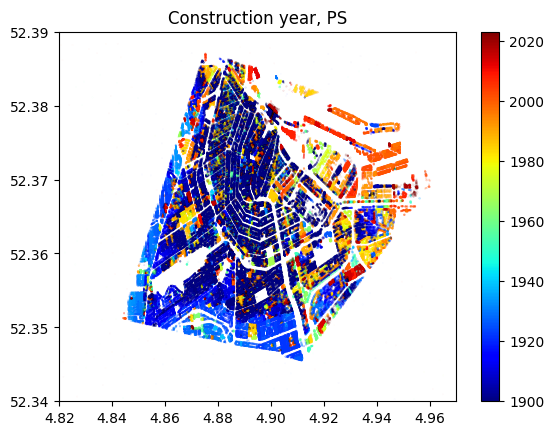

In [28]:
# Visualize results
from matplotlib import pyplot as plt
import matplotlib.cm as cm

colormap = cm.jet

fig, ax = plt.subplots()
plt.title("Construction year, PS")
plt.scatter(lon, lat, c=contextual, s=0.0001, cmap=colormap)
plt.clim([1900, 2023])
plt.xlim([4.82, 4.97])
plt.ylim([52.34, 52.39])
plt.colorbar()